# Ranger Optimization + ImageWoof

This notebook will go over how to utilize the Ranger (RAdam + LookAhead) optimizer and a `fit_flat_cos` fit function to train on the ImageWoof dataset to recreate the results found in the ImageWoof competition.

In this notebook, I will show how to use the Ranger optimizer, create a scheduler to accomidate, and a custom mxresnet architechure utilizing a Simple Self Attention layer

First let's install the libraries. You need to restart your runtime after running this line

In [1]:
!pip install Pillow --upgrade
!pip install git+https://github.com/fastai/fastai_dev > /dev/null

     |████████████████████████████████| 2.1MB 4.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


  Running command git clone -q https://github.com/fastai/fastai_dev /tmp/pip-req-build-aist6ant


# DataLoader

First let's create our `PipeLine`. For the competition we wanted to use size 448x448, so we will do so here.

In [0]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

One nice thing we can do is actually use a dictionary of labels a transform so we can turn the ImageWoof classes into something readable to us. We'll use the `DataSource` (medium level API)

In [0]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

To do this, we pass in the `__getitem__` attribute function to our transforms for our `y`'s in `get_y`

In [0]:
woof = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(valid_name='val'),
                 get_y=[parent_label, lbl_dict.__getitem__])

In [0]:
item_tfms = [FlipItem(0.5), RandomResizedCrop(128, min_scale=0.35)]

In [0]:
dbunch = woof.databunch(untar_data(URLs.IMAGEWOOF), bs=32, item_tfms=item_tfms,
                        batch_tfms=Normalize(*imagenet_stats))

Let's see what we are looking at:

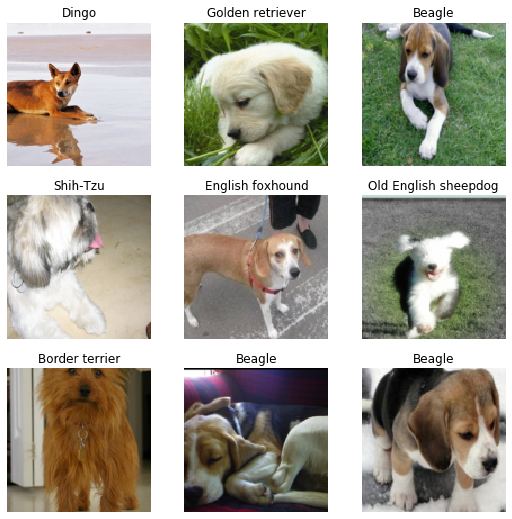

In [21]:
dbunch.show_batch()

Looks good! So now let's get to the fun stuff!

# The Pieces

All the pieces needed to run are in the library *natively* now. This includes the Ranger optimizer function (you will see how we do this in a moment), a flat-cosine annealing fit function (which is **needed** for these new optimizers), along with the Mish activation function and Simple Self Attention that we can port directly into a XResNet!

# Ranger Optimizer

Ranger in itself is really RAdam + the LookAhead optimizer. As a result, in the fastai2 library the LookAhead optimizer is moduler (as it can be applied to any optimization function). Let's see how that looks like:

In [0]:
def opt_func(ps, lr=defaults.lr): return Lookahead(RAdam(ps, wd=1e-2,mom=0.95, eps=1e-6,lr=lr))

# XResNet with Mish and Simple Self Attention

Now let's grab our architecture. This is as simple as passing in `MishJit` (an optimized Mish) for `act_cls` and `sa=True` to use Simple Self Attention

In [0]:
net = xresnet50(c_out=dbunch.c, act_cls=MishJit, sa=True)

For temporary, we are using our own `ResBlock` as we're missing one more activation for xresnet

# Training!

Now first we can find our learning rate:

In [0]:
learn = Learner(dbunch, net, opt_func=opt_func, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)

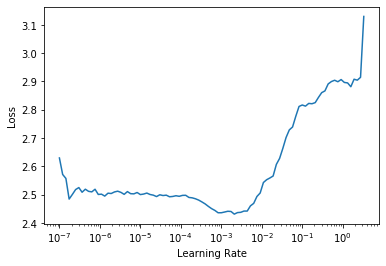

In [33]:
learn.lr_find()

As we can see, the ideal learning rate is around 4e-3. Let's fit for five epochs. During the competition it was seen that after five epochs we could get anywhere between 74.6 - 78%. Let's see how we can do!

In [34]:
learn.fit_flat_cos(5, 4e-3, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy,time
0,2.050188,2.057193,0.272000,02:20
1,1.842864,1.817589,0.390000,02:16
2,1.723886,1.844697,0.380000,02:16
3,1.596493,1.555499,0.500000,02:16
4,1.388338,1.385214,0.582000,02:16


And that is how you use these new activation functions, learning scheme, and optimizers! Happy Learning! :)

* Side note: I understand it's not quite the accuracy we are expecting, there are some issues that are being sorted out